# Home Credit Default Risk Project Notebook

### For additional information, see related notebooks:
- [EDA](./2_EDA.ipynb)
- [Merging](Features/Merge_features_train.ipynb)

Feature engineering
- [Bureau](Features/Engineering_bureau.ipynb)
- [Bureau Balance](Features/Engineering_bureau_balance.ipynb)
- [Credit Card Balance](Features/Engineering_credit_card_balance.ipynb)
- [Installments Payments](Features/Engineering_installments_payments.ipynb)
- [POS Cash](Features/Engineering_pos_cash.ipynb)
- [Previous Applications](Features/Engineering_previous_application.ipynb)

### Imports

In [66]:
### imports base

import pandas as pd
import numpy as np
from scipy import stats

### imports analysis

import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

### imports preprocessing

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(transform_output='pandas')

### set up system path to access helpers functions

# import sys, os
# src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
# if src_path not in sys.path:
#   sys.path.append(src_path)

# import helpers
from src.helpers import *

### import class balancers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

### import classifier models

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
import shap

In [67]:
# import merged data

df = pd.read_csv('data/merged_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Additional Feature Engineering

In [68]:
# engineering new features from the application dataset

df['loan_to_income_ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['monthly_debt_to_income_ratio'] = (df['AMT_ANNUITY']) / (df['AMT_INCOME_TOTAL'])

# Feature Cleaning

- 365243 is the placeholder value for those with no jobs
- I want to preserve the numeric significance of those with job (negative numbers, relative to the date of their application), but remove the skew caused by 365243
- I will replace DAYS_EMPLOYED's placeholder value of 365243 with 365

In [69]:
# replace DAYS_EMPLOYED's placeholder value of 365243 with 365

def clean_days_employed(X):
  X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'].replace(365243, 365)
  return X

preprocessor_days_employed = FunctionTransformer(clean_days_employed)

# Drop Outliers

In [70]:
# define the outlier remover custom transformer imported from src.helpers

outlier_remover = OutlierRemover(columns=[], iqr_multiplier=5)

# list the features to remove outliers from

outlier_cols = []

# create the preprocessor

preprocessor_outliers = ColumnTransformer([
  ('outlier_remover', outlier_remover, outlier_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Feature Filter

In [71]:
# list of the feature to keep

cols_original_keep = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL',
             'AMT_CREDIT','AMT_ANNUITY','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
             'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED',
             'DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL',
             'OCCUPATION_TYPE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT','WEEKDAY_APPR_PROCESS_START',
             'HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
             'DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_3','FLAG_DOCUMENT_13','FLAG_DOCUMENT_16','FLAG_DOCUMENT_18',
             'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
             'EXT_SOURCE_2','EXT_SOURCE_1','EXT_SOURCE_3']

cols_engineered_keep = ['num_bureau_records','num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                        'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                        'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                        'prev_avg_ratio_credit_approved',
                        'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                        'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA',
                        'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                        'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                        'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                        'prev_contract_type_revolving','prev_contract_type_XNA',
                        'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed']

cols_keep = cols_original_keep + cols_engineered_keep

In [166]:
# number of original features kept

len(cols_original_keep)

44

In [165]:
# number of engineered features kept

len(cols_engineered_keep)

40

In [72]:
# create a column transformer to filter unwanted columns

preprocessor_filter = ColumnTransformer([
  ('passthrough', 'passthrough', cols_keep)
], remainder='drop', verbose_feature_names_out=False)

# Imputing

In [73]:
# list the imputing features

impute_freq_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                    'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START',
                    'FLAG_OWN_CAR','FLAG_OWN_REALTY']
impute_zero_cols = ['CNT_CHILDREN','num_bureau_records',
                    'num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                    'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                    'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                    'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                    'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA']
impute_none_cols = ['OCCUPATION_TYPE']
impute_median_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY',
                      # 'AMT_GOODS_PRICE',
                      'REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT',
                      'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','HOUR_APPR_PROCESS_START',
                      'CNT_FAM_MEMBERS','prev_avg_ratio_credit_approved',
                      'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                      'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                      'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                      'prev_contract_type_revolving','prev_contract_type_XNA',
                      'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed',
                      'DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_3','FLAG_DOCUMENT_13','FLAG_DOCUMENT_16','FLAG_DOCUMENT_18',
                      'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','EXT_SOURCE_2',
                      'EXT_SOURCE_1','EXT_SOURCE_3']


# assemble the preprocess

preprocessor_imputing = ColumnTransformer([
  ('impute_most_frequent', SimpleImputer(strategy='most_frequent'), impute_freq_cols),
  ('impute_zero', SimpleImputer(strategy='constant', fill_value=0), impute_zero_cols),
  ('impute_none', SimpleImputer(strategy='constant', fill_value='None'), impute_none_cols),
  ('impute_median', SimpleImputer(strategy='median'), impute_median_cols)
], remainder='passthrough', verbose_feature_names_out=False)


# Encoding

In [74]:
# define the encoders

ohe = OneHotEncoder(drop='if_binary', min_frequency=100, sparse_output=False, handle_unknown='ignore')

# list the encoding features

ohe_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_encoding = ColumnTransformer([
  ('ohe', ohe, ohe_cols),
], remainder='passthrough', verbose_feature_names_out=False)

# Log Transform

In [75]:
# list the log features

log_transform_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY',
                      # 'AMT_GOODS_PRICE',
                      'CNT_FAM_MEMBERS']

# create a function transformer to do log transformation

def log_transform_df(X):
  return np.log1p(X)

log_transformer = FunctionTransformer(log_transform_df)


# define the preprocessor

preprocessor_log = ColumnTransformer([
  ('log_transformer', log_transformer, log_transform_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Scaling

In [76]:
# list the scaling features

standard_scaler_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY',
                        # 'AMT_GOODS_PRICE',
                        'DAYS_BIRTH',
                        'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                        'HOUR_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_scaling = ColumnTransformer([
  ('StandardScaler', StandardScaler(), standard_scaler_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Train-test-split

In [77]:
# train-test-split

X = df.drop(columns=['SK_ID_CURR','TARGET'])
y = df['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline

In [78]:
# define the main pipe

main_pipe = Pipeline([('preprocessor_days_employed', preprocessor_days_employed),
                      ('preprocessor_filter', preprocessor_filter),
                      ('preprocessor_outliers',preprocessor_outliers),
                      ('preprocessor_imputing', preprocessor_imputing),
                      ('preprocessor_encoding', preprocessor_encoding),
                      ('preprocessor_log', preprocessor_log),
                      ('preprocessor_scaling', preprocessor_scaling)
                      ])

In [79]:
# check the pipe

main_pipe

Pipeline(steps=[('preprocessor_days_employed',
                 FunctionTransformer(func=<function clean_days_employed at 0x14d381800>)),
                ('preprocessor_filter',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'NAME_TYPE_SUITE',
                                                   'N...
                                   verbose_feature_names_out=False)),
                ('preprocessor_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'HOUR_APPR_PROCESS_START'])],
                                   verbose_feature_names_out=False))])

# Modeling

In [80]:
# check the class balance

df['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [81]:
# check the class balance as a percent

df['TARGET'].value_counts() / df['TARGET'].shape

TARGET
0    0.919271
1    0.080729
Name: count, dtype: float64

- The target is imbalanced, so the model will be encouraged to predict the negative class. However, the positive class indicates default, which is what we are trying to detect. False Negatives are more costly than False Positives to the company, because a defaulted loan can be a significant loss.

### 1. Logistic Regression - Undersampling

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.74    226148
           1       0.13      0.68      0.22     19860

    accuracy                           0.61    246008
   macro avg       0.54      0.64      0.48    246008
weighted avg       0.89      0.61      0.70    246008



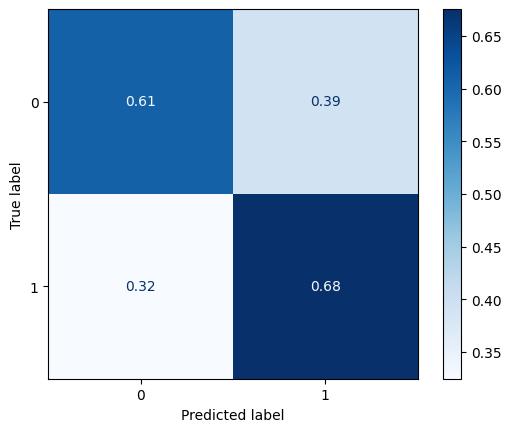

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.75     56538
           1       0.13      0.68      0.22      4965

    accuracy                           0.62     61503
   macro avg       0.54      0.65      0.49     61503
weighted avg       0.89      0.62      0.71     61503



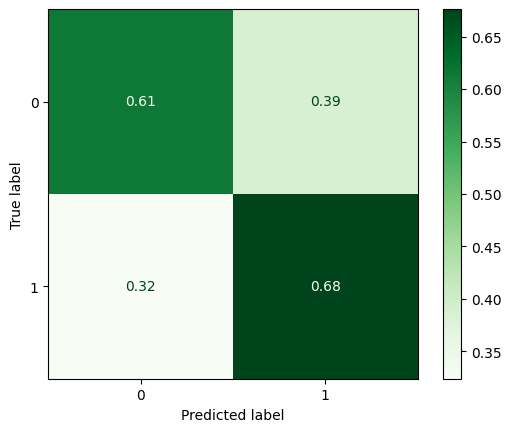

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.614923,0.618799,0.131898,0.133275,0.675428,0.676334,0.220698,0.222672,0.693414,0.698263


In [82]:
# define pipeline for LR
estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, RandomUnderSampler(), LogisticRegression(max_iter=1000))

# check the results

model_results,train_pred,test_pred = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR undersampling', pos_label=1)
model_results

### 2. Logistic Regression - Weighted

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.95      0.64      0.77    226148
           1       0.14      0.65      0.23     19860

    accuracy                           0.64    246008
   macro avg       0.55      0.65      0.50    246008
weighted avg       0.89      0.64      0.72    246008



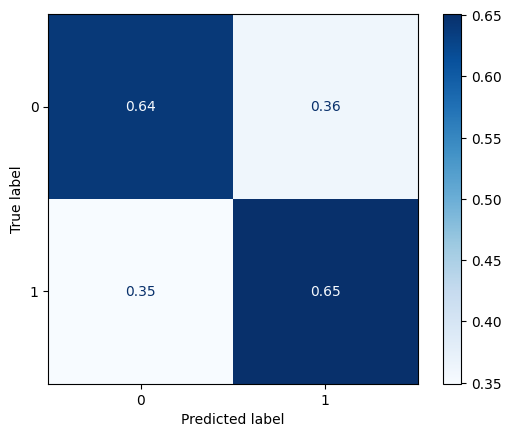

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     56538
           1       0.14      0.65      0.23      4965

    accuracy                           0.65     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.65      0.73     61503



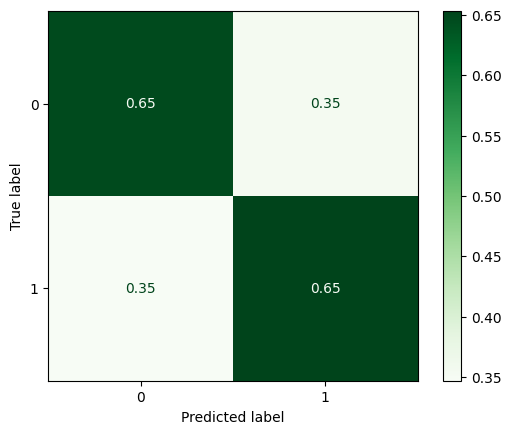

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.614923,0.618799,0.131898,0.133275,0.675428,0.676334,0.220698,0.222672,0.693414,0.698263
LR balanced,0.641012,0.646668,0.137057,0.139472,0.650806,0.653172,0.226429,0.229861,0.695179,0.700966


In [83]:
# define pipeline for LR with weighted classes

estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced'))

# check the results

model_results,train_pred,test_pred = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR balanced', pos_label=1,
                                    results_frame=model_results)
model_results

### 3. DecisionTree

Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.68      0.80    226148
           1       0.16      0.67      0.25     19860

    accuracy                           0.68    246008
   macro avg       0.56      0.68      0.53    246008
weighted avg       0.89      0.68      0.75    246008



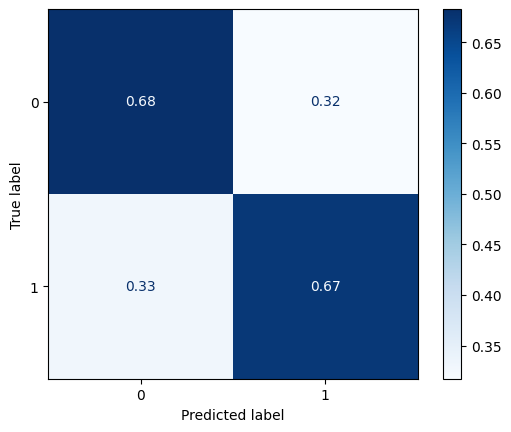

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56538
           1       0.15      0.64      0.24      4965

    accuracy                           0.68     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.68      0.75     61503



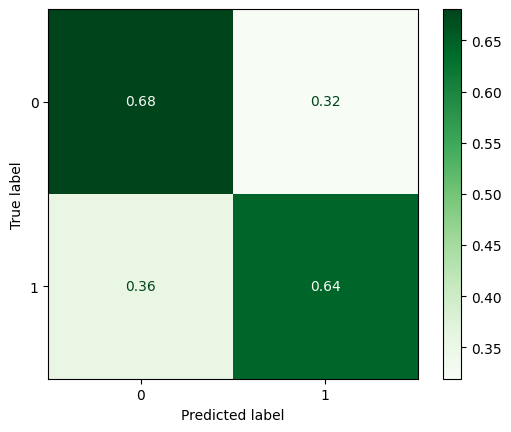

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.614923,0.618799,0.131898,0.133275,0.675428,0.676334,0.220698,0.222672,0.693414,0.698263
LR balanced,0.641012,0.646668,0.137057,0.139472,0.650806,0.653172,0.226429,0.229861,0.695179,0.700966
DecisionTree leaf=100 d=10,0.681819,0.677577,0.156580,0.150350,0.670544,0.643706,0.253877,0.243765,0.738248,0.718206


In [84]:
# define DecisionTree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, class_weight='balanced', random_state=42)

estimators = [step[1] for step in main_pipe.steps]
dt_pipe = make_pipeline(*estimators, RandomUnderSampler(), dt)

model_results,train_pred,test_pred = eval_classification(dt_pipe, X_train, y_train, X_test, y_test, model_name='DecisionTree leaf=100 d=10',
                                    results_frame=model_results)
model_results

### 4. XBGClassifier

Train Evaluation
              precision    recall  f1-score   support

           0       0.97      0.73      0.83    226148
           1       0.19      0.71      0.29     19860

    accuracy                           0.73    246008
   macro avg       0.58      0.72      0.56    246008
weighted avg       0.90      0.73      0.79    246008



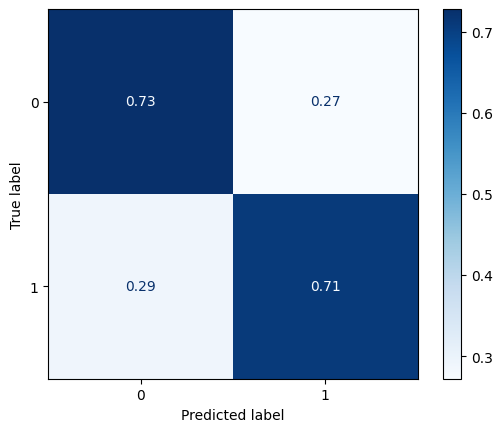

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56538
           1       0.18      0.67      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.56     61503
weighted avg       0.90      0.72      0.78     61503



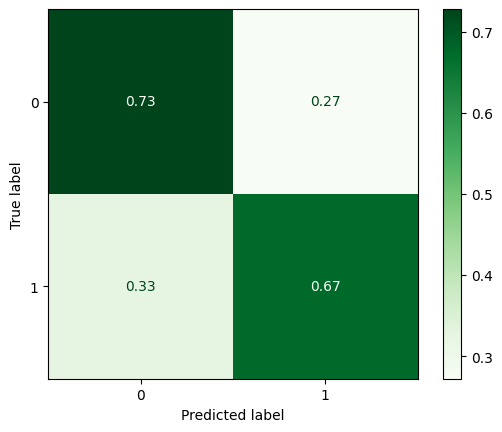

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.614923,0.618799,0.131898,0.133275,0.675428,0.676334,0.220698,0.222672,0.693414,0.698263
LR balanced,0.641012,0.646668,0.137057,0.139472,0.650806,0.653172,0.226429,0.229861,0.695179,0.700966
DecisionTree leaf=100 d=10,0.681819,0.677577,0.156580,0.150350,0.670544,0.643706,0.253877,0.243765,0.738248,0.718206
XGB balanced,0.726086,0.723168,0.186018,0.178185,0.708862,0.672508,0.294701,0.281725,0.794591,0.768486


In [85]:
# define XGBClassifier

xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, scale_pos_weight=11, random_state=42)

estimators = [step[1] for step in main_pipe.steps]
xgb_pipe = make_pipeline(*estimators, xgb)

model_results,train_pred,test_pred = eval_classification(xgb_pipe, X_train, y_train, X_test, y_test, model_name='XGB balanced',
                                    results_frame=model_results)
model_results

In [87]:
# transform table for readme

from tabulate import tabulate
print(tabulate(model_results, tablefmt="pipe", headers="keys", showindex=False))

|   train_accuracy |   test_accuracy |   train_precision |   test_precision |   train_recall |   test_recall |   train_f1 |   test_f1 |   train_auc |   test_auc |
|-----------------:|----------------:|------------------:|-----------------:|---------------:|--------------:|-----------:|----------:|------------:|-----------:|
|         0.614923 |        0.618799 |          0.131898 |         0.133275 |       0.675428 |      0.676334 |   0.220698 |  0.222672 |    0.693414 |   0.698263 |
|         0.641012 |        0.646668 |          0.137057 |         0.139472 |       0.650806 |      0.653172 |   0.226429 |  0.229861 |    0.695179 |   0.700966 |
|         0.681819 |        0.677577 |          0.15658  |         0.15035  |       0.670544 |      0.643706 |   0.253877 |  0.243765 |    0.738248 |   0.718206 |
|         0.726086 |        0.723168 |          0.186018 |         0.178185 |       0.708862 |      0.672508 |   0.294701 |  0.281725 |    0.794591 |   0.768486 |


# Check for multicollinearity using SelectNonCollinear

In [88]:
# transform train and test

X_train_processed = main_pipe.transform(X_train)
X_test_processed = main_pipe.transform(X_test)

In [174]:
# check the number of features after preprocessing

X_train_processed

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_13,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_2,EXT_SOURCE_1,EXT_SOURCE_3
181648,2.085938,-1.026723,-1.028179,-1.062115,0.855291,0.399369,-0.393927,-1.111106,1.793458,-0.102783,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.289573,0.384582,0.622922
229245,-0.624036,-1.026723,-1.505288,-1.075278,0.150020,0.760073,1.049094,0.663110,-0.036092,1.862347,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.514261,0.505446,0.535276
122525,-0.624036,-0.196844,0.599266,0.201767,-0.751224,0.103710,-0.840225,0.100877,-1.488289,1.862347,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.486906,0.505446,0.598926
306311,-0.624036,-0.196844,-0.001641,0.705330,-0.403745,0.101598,1.122579,1.093404,-1.488289,-0.102783,...,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.675705,0.505446,0.454321
300658,-0.624036,0.391966,-0.870432,0.286815,1.729030,0.386275,0.600526,1.420268,-1.488289,-0.102783,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.154565,0.505446,0.535276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,1.085768,-0.196844,-0.222095,-0.277274,0.150249,0.547621,-0.522454,-0.945353,0.994257,-0.102783,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.549668,0.505446,0.535276
121193,-0.624036,0.118662,-0.775899,-0.165241,-0.688879,-1.031621,-0.993152,0.287183,-1.488289,-0.102783,...,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.569702,0.505446,0.600658
248504,-0.624036,-1.026723,-0.916987,0.071009,-1.617857,0.953096,-1.130759,-1.088564,-0.036092,-0.102783,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.461966,0.505446,0.683269
175469,-0.624036,-0.570008,0.746841,0.242642,-1.402402,0.953096,-1.467539,-1.088564,-0.036092,1.862347,...,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.459173,0.505446,0.812823


In [89]:
# import collinearity and f_classif for determining the strength of relationship between feature and class

from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

# set a threshold
threshold = 0.7

# define the selector
selector = SelectNonCollinear(correlation_threshold=threshold, scoring=f_classif)
selector.fit(X_train_processed.values, y_train.values)

In [90]:
# create a boolean mask to decide which features to keep

selector.get_support()

X_train_lowcol = X_train_processed.loc[:, selector.get_support()]
X_test_lowcol = X_test_processed.loc[:, selector.get_support()]

X_train_lowcol.shape

(246008, 119)

In [91]:
# see which features were dropped

X_train_processed.columns.difference(X_train_lowcol.columns)

Index(['AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'CODE_GENDER_F', 'FLAG_EMP_PHONE',
       'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_TYPE_SUITE_Unaccompanied', 'num_bureau_records',
       'prev_client_type_repeater', 'prev_contract_type_cash',
       'prev_reject_HC', 'prev_reject_XAP', 'prev_status_canceled',
       'prev_status_unused'],
      dtype='object')

In [92]:
# re-train model

xgb = xgb.fit(X_train_lowcol, y_train)

# Use Permutation Importance to Filter Features

In [93]:
# get the permutation importances
# resample to reduce computation

from sklearn.utils import resample

X_train_lowcol_sample, y_train_sample = resample(X_train_lowcol, y_train, n_samples=10000, random_state=42)

importances = permutation_importance(xgb, X_train_lowcol_sample, y_train_sample, random_state=42, scoring='roc_auc', n_repeats=5)

In [94]:
# put the importances in a dataframe

importances_df = pd.DataFrame(importances.importances_mean, index=X_train_lowcol.columns)
importances_df.columns = ['importance']
importances_df

,importance
CNT_CHILDREN,0.000040
AMT_INCOME_TOTAL,0.001839
AMT_CREDIT,0.010810
DAYS_BIRTH,0.011473
DAYS_EMPLOYED,0.004540
...,...
AMT_REQ_CREDIT_BUREAU_QRT,0.000495
AMT_REQ_CREDIT_BUREAU_YEAR,0.000406
EXT_SOURCE_2,0.030314
EXT_SOURCE_1,0.020067


In [95]:
# sort the importances to see the highest feature importances

importances_df.sort_values(by='importance', ascending=False)

,importance
EXT_SOURCE_3,0.038768
EXT_SOURCE_2,0.030314
EXT_SOURCE_1,0.020067
DAYS_BIRTH,0.011473
AMT_CREDIT,0.010810
...,...
REG_REGION_NOT_WORK_REGION,0.000000
OCCUPATION_TYPE_Waiters/barmen staff,0.000000
WEEKDAY_APPR_PROCESS_START_FRIDAY,-0.000004
NAME_FAMILY_STATUS_Single / not married,-0.000008


In [96]:
# create a boolean mask for importances above 0.001

imp_mask = importances_df['importance'] > 0.001
imp_mask.value_counts()

importance
False    89
True     30
Name: count, dtype: int64

In [173]:
# apply the importance mask to the train and test

X_train_imp = X_train_lowcol.loc[:, imp_mask]
X_test_imp = X_test_lowcol.loc[:, imp_mask]

X_train_imp.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,...,prev_avg_ratio_credit_approved,prev_status_approved,prev_status_refused,prev_yield_high,prev_yield_low_action,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_16,EXT_SOURCE_2,EXT_SOURCE_1,EXT_SOURCE_3
181648,-1.026723,-1.028179,0.855291,0.399369,-0.393927,-1.111106,-0.102783,-0.631564,0.0,0.0,...,1.024200,5.0,0.0,2.0,0.0,0.0,0.0,0.289573,0.384582,0.622922
229245,-1.026723,-1.505288,0.150020,0.760073,1.049094,0.663110,1.862347,0.287514,0.0,1.0,...,1.056443,4.0,1.0,0.0,0.0,-509.0,0.0,0.514261,0.505446,0.535276
122525,-0.196844,0.599266,-0.751224,0.103710,-0.840225,0.100877,1.862347,-2.163362,0.0,1.0,...,0.929718,1.0,0.0,1.0,0.0,-1474.0,0.0,0.486906,0.505446,0.598926
306311,-0.196844,-0.001641,-0.403745,0.101598,1.122579,1.093404,-0.102783,-0.631564,0.0,1.0,...,1.082621,6.0,2.0,3.0,0.0,-2016.0,0.0,0.675705,0.505446,0.454321
300658,0.391966,-0.870432,1.729030,0.386275,0.600526,1.420268,-0.102783,-2.163362,0.0,0.0,...,0.995030,1.0,1.0,1.0,0.0,-695.0,0.0,0.154565,0.505446,0.535276


In [98]:
# re-train model

xgb_imp = xgb.fit(X_train_imp, y_train)

Train Evaluation
              precision    recall  f1-score   support

           0       0.97      0.72      0.83    226148
           1       0.18      0.71      0.29     19860

    accuracy                           0.72    246008
   macro avg       0.57      0.71      0.56    246008
weighted avg       0.90      0.72      0.78    246008



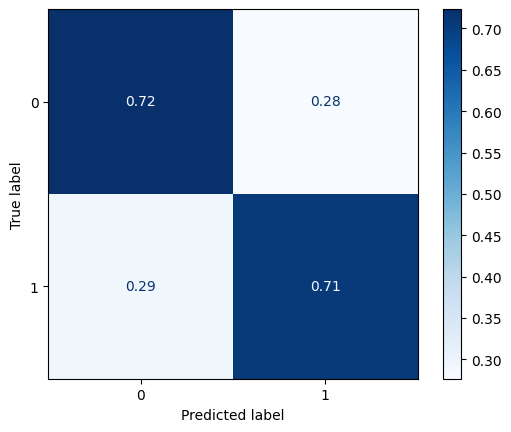

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.72      0.83     56538
           1       0.18      0.68      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.72      0.78     61503



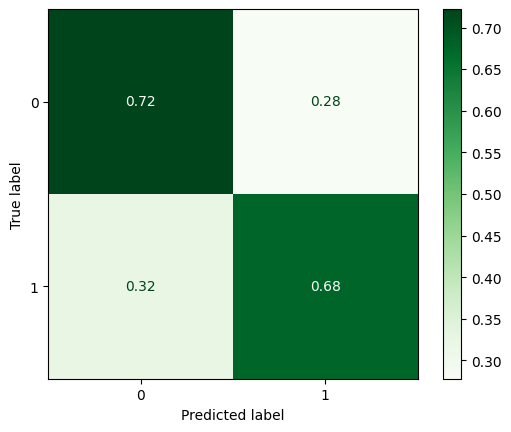

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.614923,0.618799,0.131898,0.133275,0.675428,0.676334,0.220698,0.222672,0.693414,0.698263
LR balanced,0.641012,0.646668,0.137057,0.139472,0.650806,0.653172,0.226429,0.229861,0.695179,0.700966
DecisionTree leaf=100 d=10,0.681819,0.677577,0.156580,0.150350,0.670544,0.643706,0.253877,0.243765,0.738248,0.718206
XGB balanced,0.726086,0.723168,0.186018,0.178185,0.708862,0.672508,0.294701,0.281725,0.794591,0.768486
XGB Balanced w/Feature Selection,0.721940,0.718436,0.183139,0.176174,0.706395,0.676737,0.290868,0.279569,0.789211,0.765326


In [124]:
# review the performance with selected features

model_results,train_pred,test_pred = eval_classification(xgb, X_train_imp, y_train, X_test_imp, y_test, model_name='XGB Balanced w/Feature Selection',
                                    results_frame=model_results)
model_results

In [160]:
# calculating the uplift from XGB with original features to the XGB with selected features

XGB_results = model_results.iloc[3:5].reset_index().rename(columns={'index': 'model_name'}).T
XGB_results.columns = XGB_results.iloc[0]
XGB_results.drop(index='model_name', inplace=True)
XGB_results['Uplift'] = XGB_results['XGB Balanced w/Feature Selection'] - XGB_results['XGB balanced']
XGB_results.columns = ['XGB w/231 features', 'XGB w/30 features', 'Uplift']
XGB_results

,XGB w/231 features,XGB w/30 features,Uplift
train_accuracy,0.726086,0.72194,-0.004146
test_accuracy,0.723168,0.718436,-0.004731
train_precision,0.186018,0.183139,-0.002879
test_precision,0.178185,0.176174,-0.00201
train_recall,0.708862,0.706395,-0.002467
test_recall,0.672508,0.676737,0.00423
train_f1,0.294701,0.290868,-0.003833
test_f1,0.281725,0.279569,-0.002156
train_auc,0.794591,0.789211,-0.00538
test_auc,0.768486,0.765326,-0.003159


In [162]:
# transform table for readme

print(tabulate(XGB_results, tablefmt="pipe", headers="keys", showindex=True))

|                 |   XGB w/231 features |   XGB w/30 features |      Uplift |
|:----------------|---------------------:|--------------------:|------------:|
| train_accuracy  |             0.726086 |            0.72194  | -0.00414621 |
| test_accuracy   |             0.723168 |            0.718436 | -0.00473148 |
| train_precision |             0.186018 |            0.183139 | -0.00287859 |
| test_precision  |             0.178185 |            0.176174 | -0.00201004 |
| train_recall    |             0.708862 |            0.706395 | -0.00246727 |
| test_recall     |             0.672508 |            0.676737 |  0.00422961 |
| train_f1        |             0.294701 |            0.290868 | -0.0038327  |
| test_f1         |             0.281725 |            0.279569 | -0.00215561 |
| train_auc       |             0.794591 |            0.789211 | -0.00538037 |
| test_auc        |             0.768486 |            0.765326 | -0.00315918 |


In [99]:
# cross validate to verify scores

from sklearn.model_selection import cross_validate

cross_validate(xgb, X_train_imp, y_train, cv=5, scoring='roc_auc', return_train_score=True)

{'fit_time': array([0.54134917, 0.50419593, 0.50995517, 0.49054289, 0.48818302]),
 'score_time': array([0.01898813, 0.01982307, 0.01937795, 0.02130198, 0.01926613]),
 'test_score': array([0.76420094, 0.75033393, 0.76435747, 0.76560124, 0.76552389]),
 'train_score': array([0.79443787, 0.79593231, 0.79353506, 0.7922662 , 0.7934781 ])}

# Predict Test

In [100]:
# import test data
kaggle_test = pd.read_csv('data/merged_test.csv')

# save the id column
kaggle_columns = kaggle_test['SK_ID_CURR']

# process kaggle data
kaggle_proc = main_pipe.transform(kaggle_test)
kaggle_proc_lowcol = kaggle_proc.loc[:, selector.get_support()]
kaggle_proc_masked = kaggle_proc_lowcol.loc[:,imp_mask]
kaggle_proc_masked

,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,...,prev_avg_ratio_credit_approved,prev_status_approved,prev_status_refused,prev_yield_high,prev_yield_low_action,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_16,EXT_SOURCE_2,EXT_SOURCE_1,EXT_SOURCE_3
0,-0.196844,0.252683,-0.736096,-0.184769,-0.051188,1.446789,-0.102783,1.819311,0.0,0.0,...,0.957782,1.0,0.0,1.0,0.0,-1740.0,0.0,0.789654,0.752614,0.159520
1,-0.831649,-1.057685,-0.466319,-1.088640,-1.171331,0.909087,-0.102783,-0.937924,0.0,1.0,...,0.899950,1.0,0.0,1.0,0.0,0.0,0.0,0.291656,0.564990,0.432962
2,0.633037,0.467459,-0.918774,-1.083994,0.798566,-0.337373,-0.102783,0.593873,0.0,1.0,...,1.052363,3.0,0.0,1.0,0.0,-856.0,0.0,0.699787,0.505446,0.610991
3,1.537355,1.676398,0.470681,0.010788,0.848217,-0.804795,-0.102783,-0.325205,0.0,0.0,...,0.975609,3.0,0.0,0.0,1.0,-1805.0,0.0,0.509677,0.525734,0.612704
4,0.391966,0.385513,0.685219,-0.126482,0.280769,-0.840598,-0.102783,-2.163362,0.0,1.0,...,1.131358,1.0,0.0,1.0,0.0,-821.0,0.0,0.425687,0.202145,0.535276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.412489,-0.196242,-0.903188,-1.384299,-1.164522,-0.268420,1.862347,1.206592,0.0,0.0,...,1.132000,1.0,0.0,0.0,0.0,-684.0,0.0,0.648575,0.505446,0.643026
48740,0.118662,0.378597,1.110170,0.313628,0.560237,-0.005867,-0.102783,-0.325205,0.0,0.0,...,1.096814,4.0,0.0,3.0,1.0,0.0,0.0,0.684596,0.505446,0.535276
48741,0.633037,-0.573402,0.024643,-0.483807,0.655001,0.987986,-0.102783,-0.018845,0.0,0.0,...,0.949988,2.0,0.0,0.0,0.0,-838.0,0.0,0.632770,0.733503,0.283712
48742,0.848683,-0.074814,0.472515,-0.354562,1.001145,1.080807,-0.102783,-0.631564,0.0,1.0,...,1.102514,2.0,2.0,3.0,0.0,-2308.0,0.0,0.445701,0.373090,0.595456


In [101]:
# predict kaggle

kaggle_preds = xgb_imp.predict(kaggle_proc_masked)

# save the prediction into the kaggle format and check values

prediction_df = pd.DataFrame({'SK_ID_CURR': kaggle_columns,'TARGET': kaggle_preds})
prediction_df

,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,0
3,100028,0
4,100038,1
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,1


In [102]:
# check the class balance of the predictions

prediction_df['TARGET'].value_counts()

TARGET
0    34220
1    14524
Name: count, dtype: int64

In [103]:
# export predictions to submission csv

# prediction_df.to_csv('../submissions/submission14_col_imp_masks_30feats.csv', index=False)

# Analyze the Feature Importances

In [104]:
# save the importances in the final model

imp_df = importances_df.reset_index()
imp_df.columns = ['Feature', 'Importance']
imp_df = imp_df[imp_df['Importance'] > 0.001]
imp_df = imp_df.sort_values(by='Importance', ascending=False)
imp_df.head()

,Feature,Importance
118,EXT_SOURCE_3,0.038768
116,EXT_SOURCE_2,0.030314
117,EXT_SOURCE_1,0.020067
3,DAYS_BIRTH,0.011473
2,AMT_CREDIT,0.010810


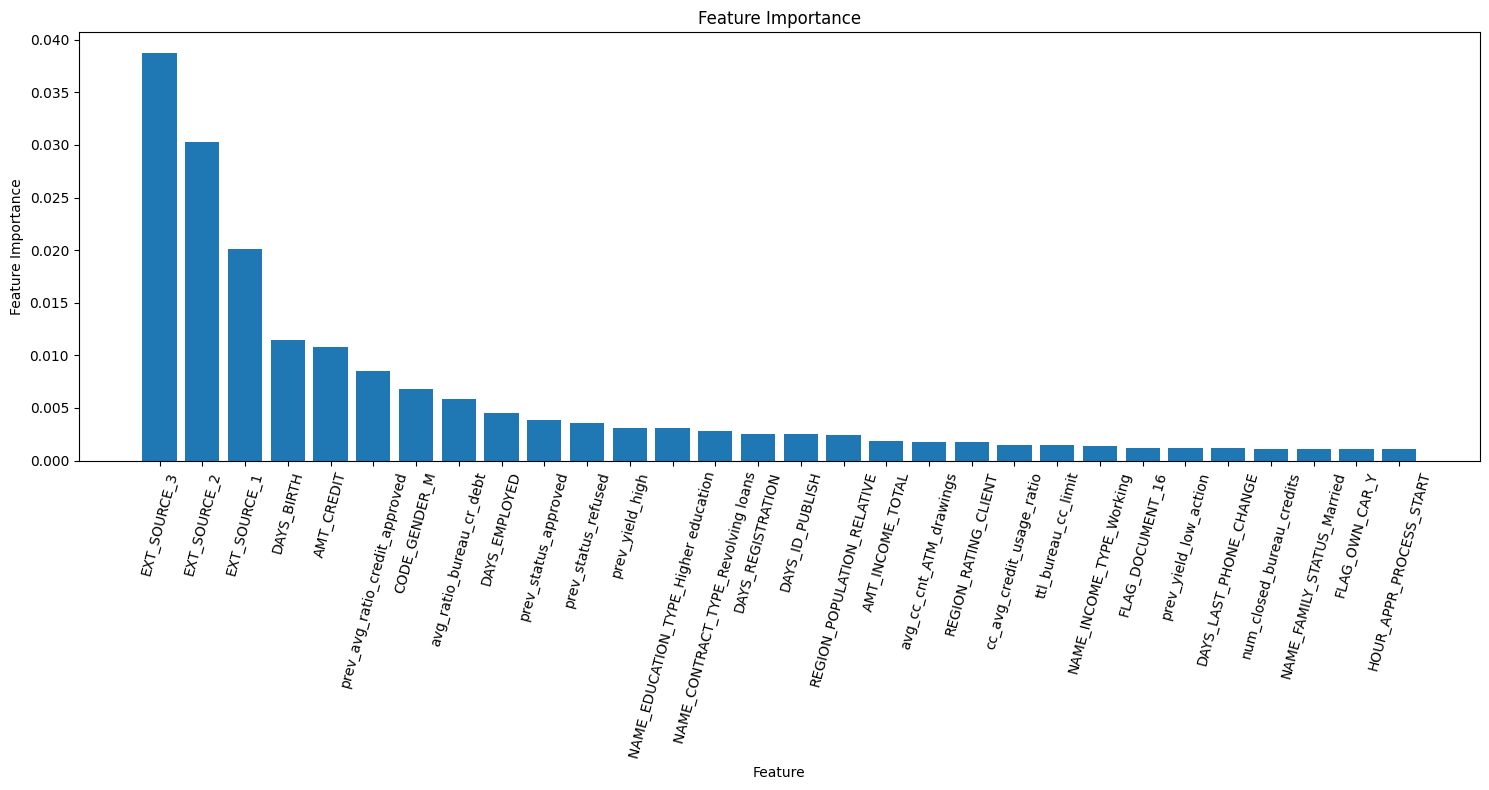

In [105]:
# plot the importances

plt.figure(figsize=(15,8))
plt.bar(imp_df['Feature'], imp_df['Importance'])
plt.xticks(rotation=75)
plt.title('Feature Importance')
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.tight_layout()


Observations based the model's highest feature importances:
- The 3 external sources, which are suspected to be scores from the 3 major credit bureaus, are the most important features to this model
- DAYS_BIRTH and CODE_GENDER_M raise questions about discrimination and should be recommended to be removed from the model
- Previous application decisions seem to drive future predictions, features that relate to prior financial obligations include:
    - prev_avg_ratio_credit_approved: the ratio of credit applied to credit approved on previous applications
    - prev_status_approved: count of approved previous application
    - prev_status_refused: count of refused previous applications
    - prev_yield_high: when a previous application was deemed to require a high interest rate, which can indicate higher risk
    - prev_yield_low_action: this is when a previous application was provided a low interest rate, not necessarily due to credit worthiness, but due to some type of promotion the company was offering at that time
- Credit Card utilization behavior is utilized by the model to make predictions, these features include:
    - avg_cc_cnt_ATM_drawings: the average number of ATM drawings per month per credit card, averaged per client
    - cc_avg_credit_usage_ratio: the average ratio of credit card balance to credit card limit
- Being employed is also a major factor that the model considers. These include the following features:
    - DAYS_EMPLOYED
    - NAME_INCOME_TYPE_Working
- Employment is also related to stability, which ties to a few other features that the model found indicative:
    - DAYS_REGISTRATION: this is how long ago did the client change their registration
    - DAYS_ID_PUBLISH: this is how long ago did the client change the identity document that was used to apply for the loan
    - DAYS_LAST_PHONE_CHANGE: this is how long ago did the client last change their phone number


In [106]:
# check permutation importances

estimators = [step[1] for step in main_pipe.steps]
xgb_model = xgb.fit(X_train_imp, y_train)

In [107]:
# use SHAP to evaluate feature importances

X_train_imp_sample = X_train_imp.sample(10000)

explainer = shap.Explainer(xgb_model, X_train_imp_sample)
shap_values = explainer(X_train_imp_sample)

 99%|===================| 9884/10000 [00:17<00:00]        

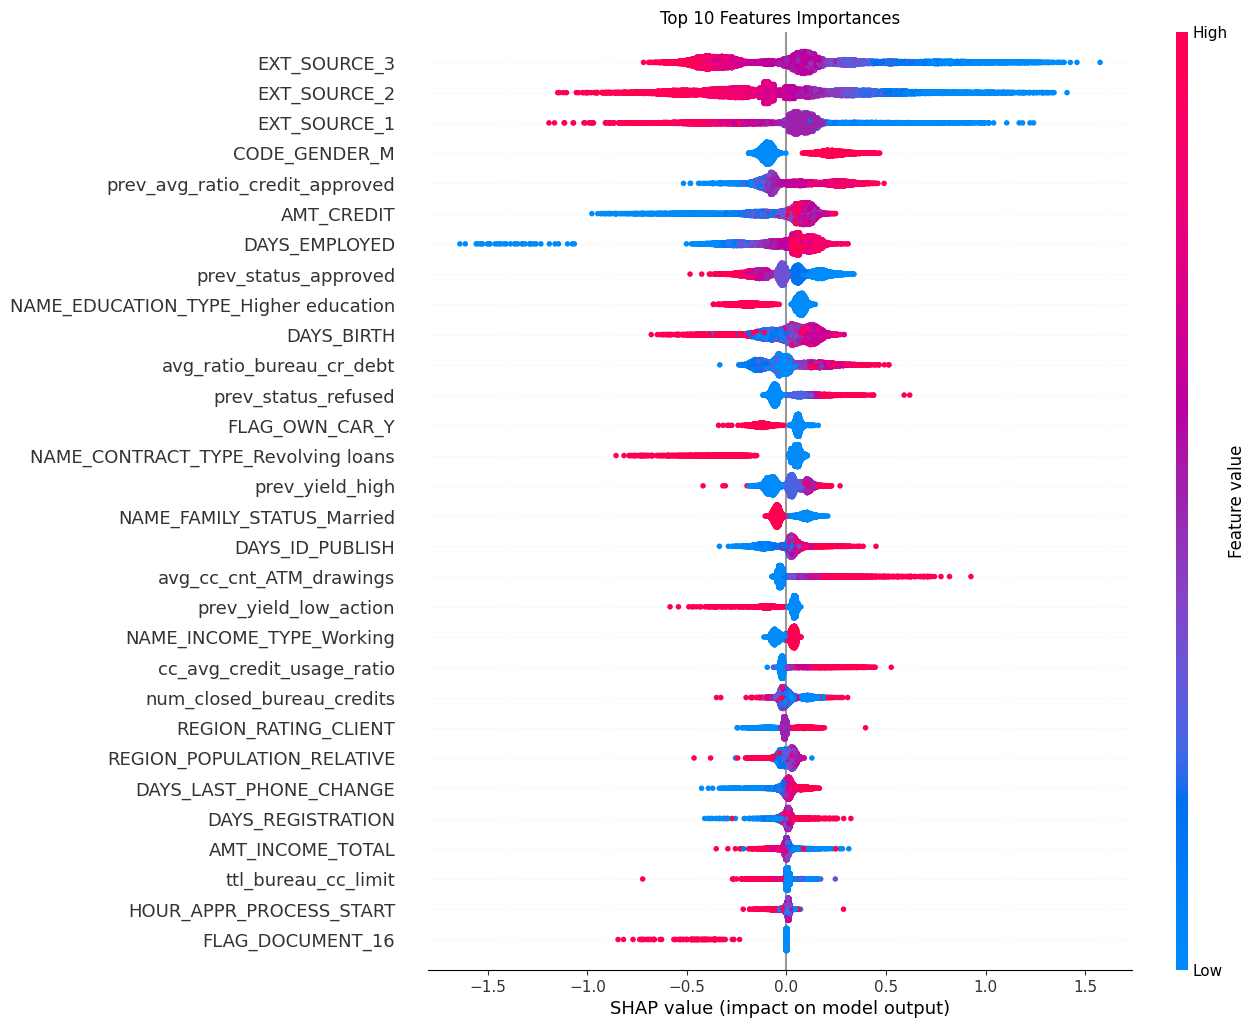

In [108]:
# plot the SHAP summary plot to see the impact of top 50 features

shap.summary_plot(shap_values, X_train_imp_sample, feature_names=X_train_imp.columns, show=False, max_display=30)
plt.gcf().set_size_inches(20,10)
plt.gcf().savefig('shap_plot_10.png', dpi=300)
plt.title('Top 10 Features Importances')
plt.show()

Analysis of the SHAP Plot

- As expected, lower credit bureau scores drive predictions towards default
- Larger loans are predicted to be more likely to default
- The model is biased against male applications, this raises a concern of discrimination. Feature should be removed.
- The model utilizes age in its prediction, but it does not appear that the relationship is linear across age. Regardless, this features needs to be reconsidered due to discrimination.
- Not owning a car is a driver of default in this model. I will check the correlation of the raw data to see if the correlation shows similar tendencies. 

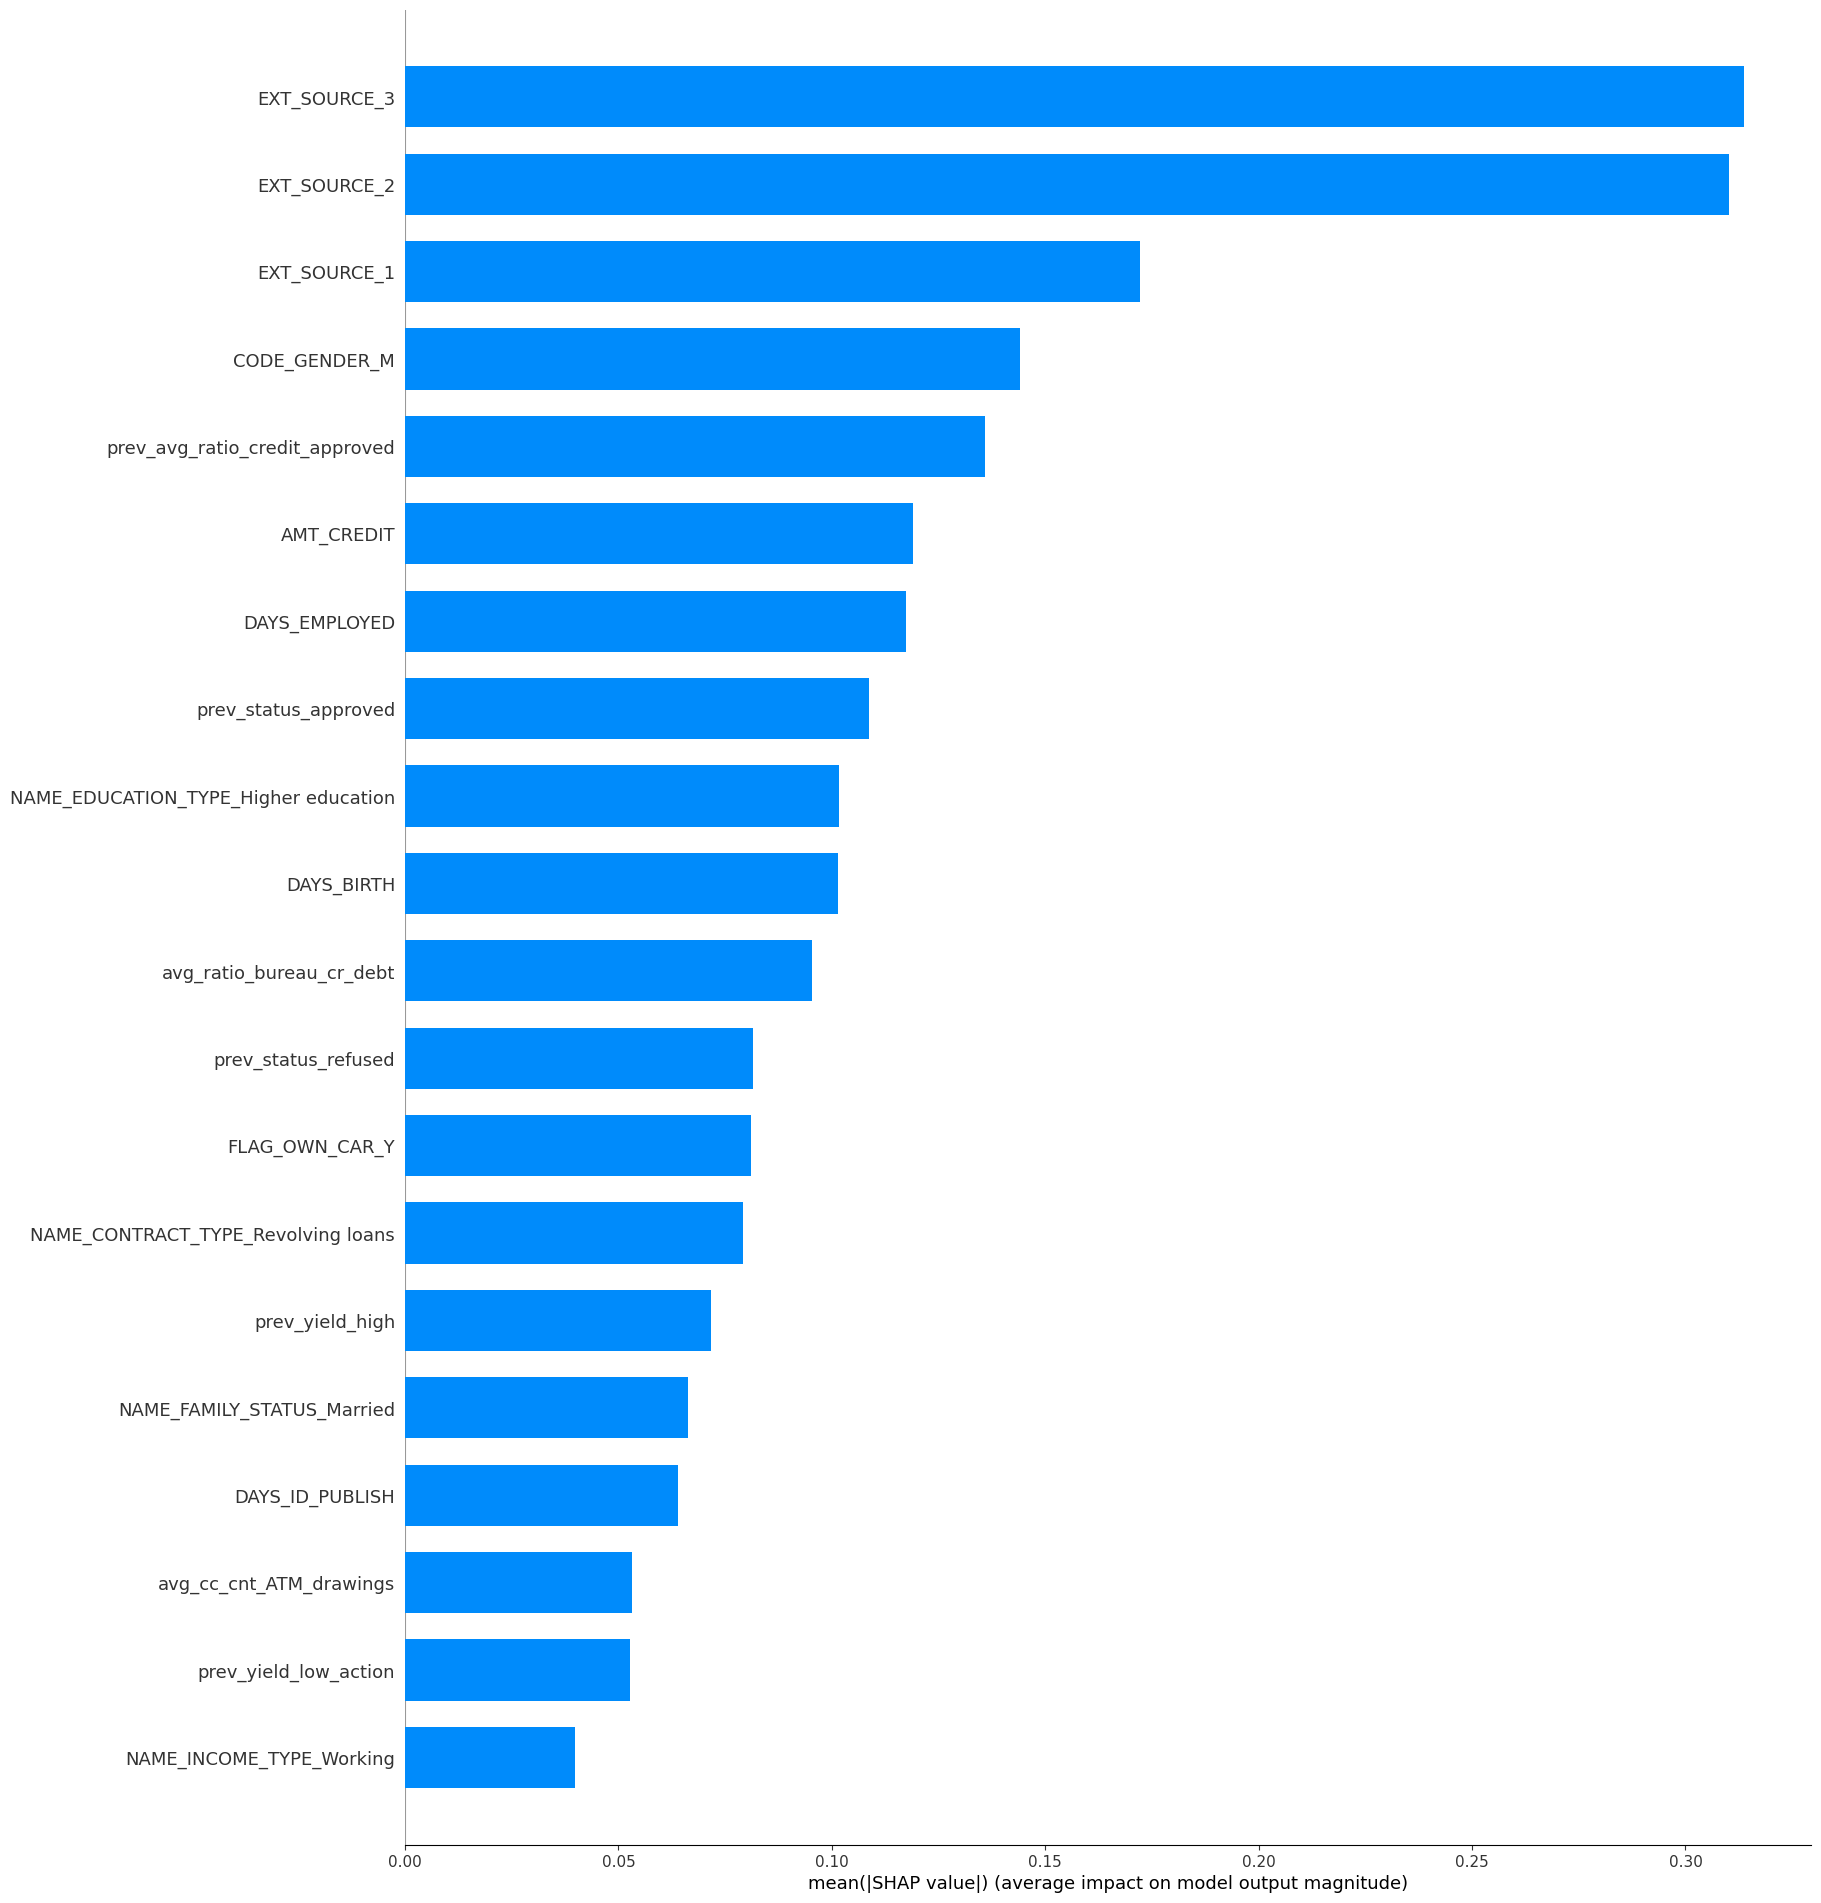

In [109]:
# plot the shap summary plot

shap.summary_plot(shap_values, X_train_imp_sample, feature_names=X_train_imp.columns, plot_type='bar', max_display=20, show=False)
plt.gcf().set_size_inches(30,20)
plt.show()

In [110]:
# Create a DataFrame with feature importance

feature_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train_imp.columns,
    'importance': feature_importance
})

feature_importance_df.sort_values(by='importance', ascending=False)

,feature,importance
29,EXT_SOURCE_3,0.313796
27,EXT_SOURCE_2,0.310300
28,EXT_SOURCE_1,0.172092
9,CODE_GENDER_M,0.144180
20,prev_avg_ratio_credit_approved,0.135786
1,AMT_CREDIT,0.119019
3,DAYS_EMPLOYED,0.117349
21,prev_status_approved,0.108722
12,NAME_EDUCATION_TYPE_Higher education,0.101775
2,DAYS_BIRTH,0.101355


# Plot Correlations

In [111]:
# clean DAYS_EMPLOYED

df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243,365)

# take a random sample of the original to increase plotting speed

df_sampled = df.sample(10000, random_state=42)
df_sampled.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,loan_to_income_ratio,monthly_debt_to_income_ratio
245895,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.248587,0.254304
98194,214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.178636,0.197764
36463,142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.444444,0.193133
249923,389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029091,0.100764
158389,283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.738960,0.141000


In [112]:
# take a random sample of the processed data to decrease plotting burden

train_imp_sampled = X_train_imp.join(y_train)
train_imp_sampled = train_imp_sampled.sample(10000, random_state=42)

### DAYS_EMPLOYED vs TARGET

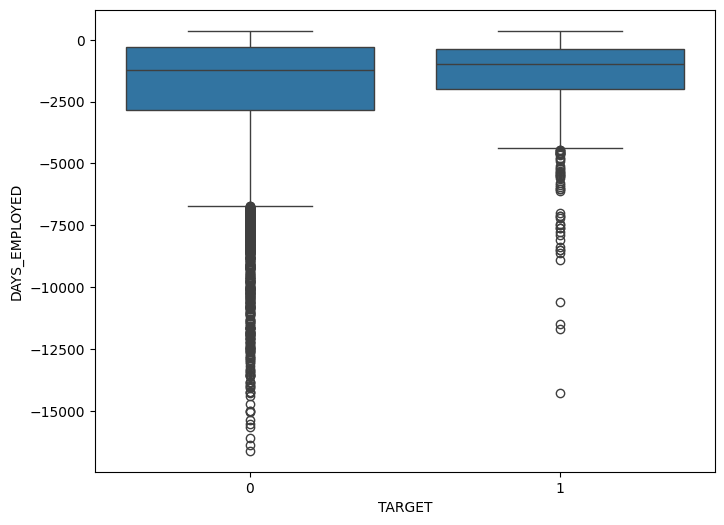

In [113]:
# plot correlations - boxplot

plt.figure(figsize=(8,6))
sns.boxplot(x=df_sampled['TARGET'], y=df_sampled['DAYS_EMPLOYED'])
plt.savefig("days_employed_box_transparent.png", transparent=True)
plt.show()

- The target, default, is correlated with a shorter employment period. 

### cc_avg_credit_usage_ratio vs TARGET

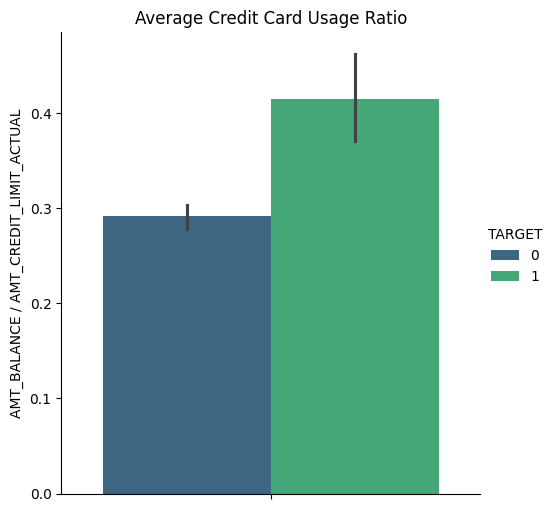

In [114]:
sns.catplot(
    data=df_sampled, y="cc_avg_credit_usage_ratio", hue="TARGET", kind="bar",
    palette="viridis")
plt.title('Average Credit Card Usage Ratio')
plt.ylabel('AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL')
plt.savefig("cc_avg_credit_usage_ratio_transparent.png", transparent=True)
plt.show()

- A higher average credit card balance to limit ratio is notably more correlated with default

### AMT_GOODS_PRICE

<Axes: ylabel='Density'>

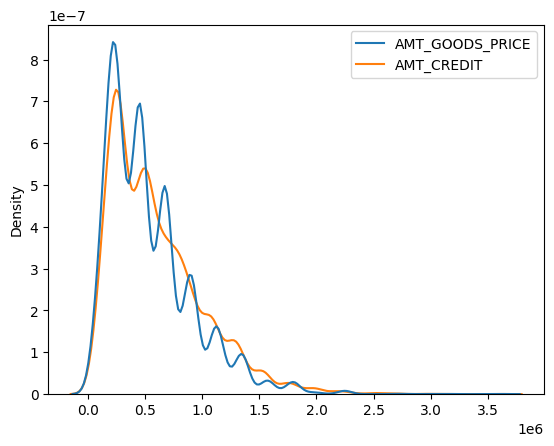

In [115]:
sns.kdeplot(data=df_sampled[['AMT_GOODS_PRICE','AMT_CREDIT']])

- AMT_GOODS_PRICE and AMT_CREDIT are highly correlated. AMT_GOODS_PRICE was dropped from the model.

### avg_cc_cnt_ATM_drawings

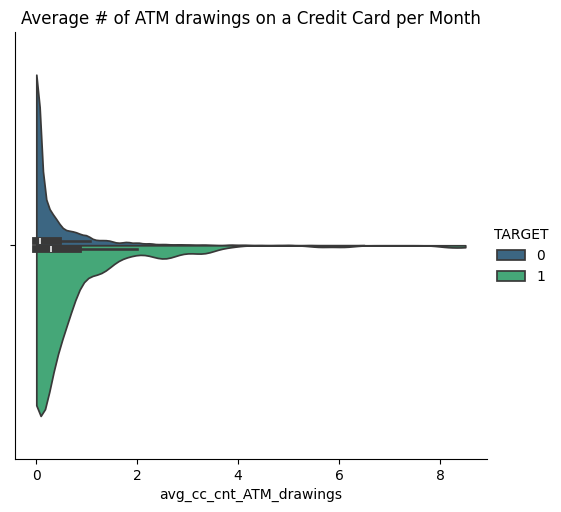

In [116]:
sns.catplot(
    data=df_sampled, x="avg_cc_cnt_ATM_drawings", hue="TARGET",
    kind="violin", bw_adjust=.5, cut=0, split=True, palette='viridis'
)
plt.title('Average # of ATM drawings on a Credit Card per Month')
plt.savefig("avg_num_ATM_transparent.png", transparent=True);

- The average number of ATM drawings per credit card per month correlates more ATM drawings to more likelihood of default.

### NAME_CONTRACT_TYPE

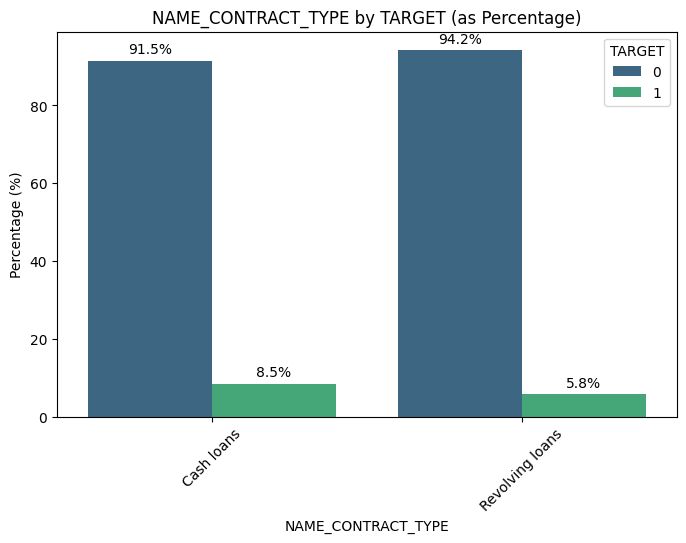

In [117]:
# plot the percentage of default for clients based on the region rating

barplot_by_percentage(df_sampled, 'NAME_CONTRACT_TYPE', 'TARGET')

- Cash loans are more likely to default than revolving loans.

### REGION_RATING_CLIENT

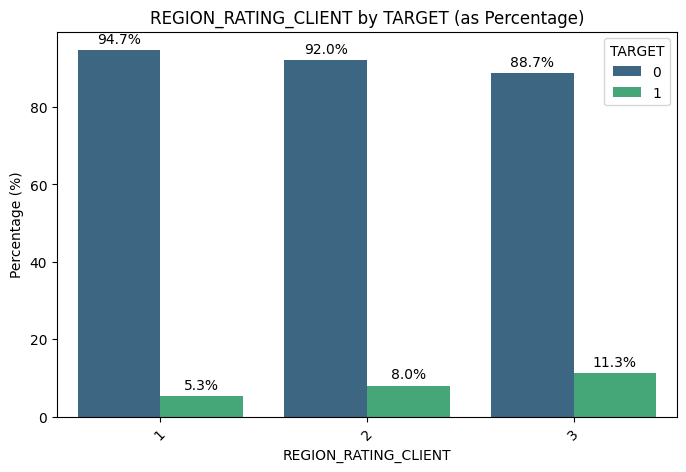

In [118]:
# plot the percentage of default for clients based on the region rating

barplot_by_percentage(df_sampled, 'REGION_RATING_CLIENT', 'TARGET')

- The company's rating of the region where the client lives (1,2,3) clearly show a difference in default rates between clients living in different regions. 

### NAME_EDUCATION_TYPE

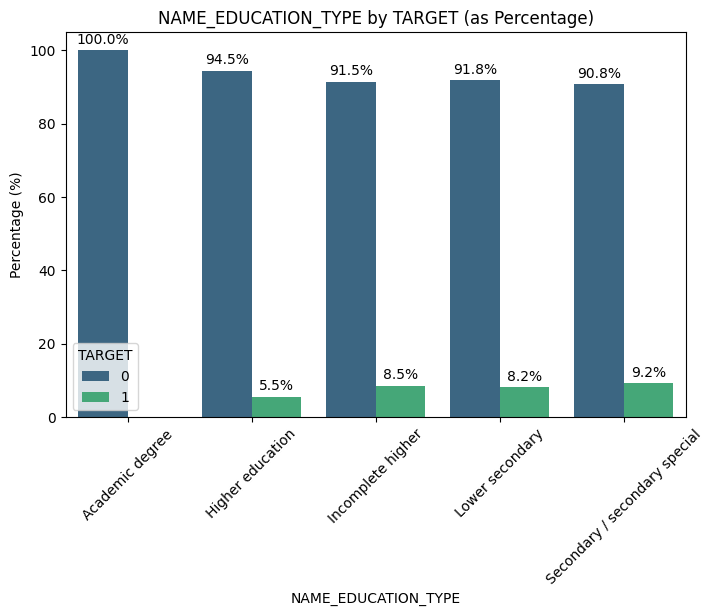

In [119]:
# plot the percentage of default for clients with different levels of education

barplot_by_percentage(df_sampled, 'NAME_EDUCATION_TYPE', 'TARGET')

In [120]:
# check the percentages of value counts

df['NAME_EDUCATION_TYPE'].value_counts() / df['NAME_EDUCATION_TYPE'].shape

NAME_EDUCATION_TYPE
Secondary / secondary special    0.710189
Higher education                 0.243448
Incomplete higher                0.033420
Lower secondary                  0.012409
Academic degree                  0.000533
Name: count, dtype: float64

In [121]:
# check the count of types

df['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64

- Although Academic degree has a 100% rate of non-default, this may be due to chance since it makes up only 0.0533% of the sample set with 164 records.
- Only higher education seems to correlate to a significantly lower rate of default than the other education types

### FLAG_OWN_CAR

<Figure size 640x480 with 0 Axes>

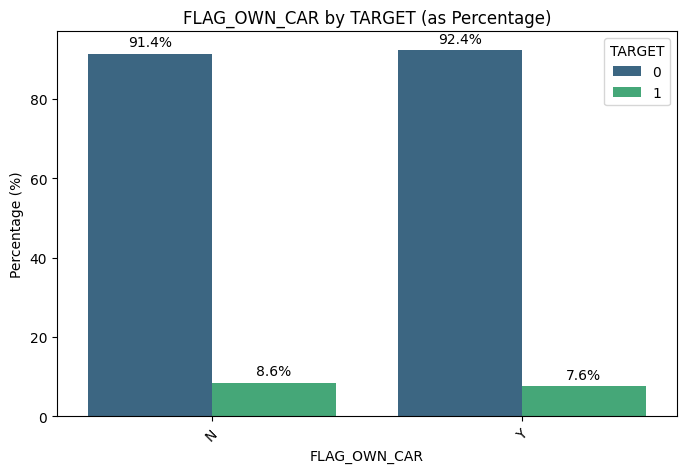

In [122]:
# plot the percentage of default for clients who own a car and those who don't

plt.figure()
barplot_by_percentage(df_sampled, 'FLAG_OWN_CAR', 'TARGET')

- Clients who own a car has a lower rate of default in this dataset. This makes sense, because purchasing a vehicle also requires obtaining a loan. If the client was approved for a car loan, they are more likely to qualify for a home loan than someone who was not approved for a car loan.